# Starting point: Big Query and London Crime
This is my first attempt at looking at a dataset where the data is provided in the Big Query format on Kaggle. Getting to know how to use the Big Query datasets on Kaggle will allow me, in the future, to tackle some of the larger datasets and provide an opportunity to practise SQL queries on large databases that I am not familiar with. This is intended as a starting point for those that are keen to tackle Big Query datasets but aren't quite sure where to start. 

Firstly, let's see if we can read the data in and extract some insight with maybe a few plots. 

In [1]:
# Usual imports that are needed for most analysis
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

We are working with Big Query, so we are going to use a special package that allows us to the connect to the database, see things about the database, and run queries against it using SQL to extract information. More information about the package can be found [here](https://www.kaggle.com/sohier/introduction-to-the-bq-helper-package), and more generally getting started with Big Query can be found [here](https://www.kaggle.com/dansbecker/getting-started-with-sql-and-bigquery).

In [4]:
%%bash
export GOOGLE_APPLICATION_CREDENTIALS="/home/tpin3694/Documents/phd-hours-81c4006f26e7.json"

In [5]:
import bq_helper
london = bq_helper.BigQueryHelper(active_project="bigquery-public-data", dataset_name="london_crime")

## Initial exploration and get some data
Now that we have access to the big query database, under the variable name `london` we can see what tables are included using the `.list_tables()` method. We can see below, in our case we have just the one table, so the reading in is simple with no joins required to get our hands on all the information. 

In [7]:
london.list_tables()

['crime_by_lsoa']

Let's have a look at the first few rows to get our bearings, using the `head()` method. 

In [9]:
london.head('crime_by_lsoa') 

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01032740,City of London,Violence Against the Person,Harassment,0,2016,11
1,E01000005,City of London,Violence Against the Person,Harassment,0,2011,3
2,E01032739,City of London,Violence Against the Person,Harassment,0,2016,12
3,E01000005,City of London,Violence Against the Person,Harassment,0,2011,11
4,E01000005,City of London,Violence Against the Person,Harassment,0,2014,3


We can see that we have  7 columns: 
- **lsoa_code**: this represents a policing area 
- **borough**: the london borough for which the statistic is related
- **major_category**: the major crime category
- **minor_category**: the minor crime category
- **value**: the count of the crime for that particular borough, in that particular month
- **year**: the year of the summary statistic
- **month**: the month of the summary statistic

## How many boroughs?
Now that we have a better understanding of the data at our disposable, we can start thinking about the sort of questions that we might be able to ask. 

Let's start with a simple query to get started to see how many boroughs are represented in the `crime_by_lsoa` table. 

Querying the data takes, at its simplest, two steps:
1. Writing a query to perform
2. Performing the query and storing the information (in my case as a pandas data frame)

In [10]:
# Write the query that we want to perform
# Select the distinct boroughs from our one table
boroughs_count = """
SELECT DISTINCT borough
FROM `bigquery-public-data.london_crime.crime_by_lsoa`;
        """

# Perform the query and store the result
boroughs = london.query_to_pandas_safe(boroughs_count)
boroughs

,borough
0,City of London
1,Brent
2,Barnet
3,Bexley
4,Camden
5,Ealing
6,Harrow
7,Merton
8,Newham
9,Sutton


This tells us that we 33 boroughs that we could potentially investigate. 
Let's perform another, slightly more complicated (with grouping and a summary variable), query to see what is happening with general crime rates in Camden, as an example. 

## Crime in Camden
To track this over time, we are going to filter by `borough`, group by the `year` and `month` and get the sum of all recorded crimes (I will alias this as `total_crime`). 

In [11]:
# Query to select Camden's crime stats by year and month
camden_crime_query = """
SELECT year, month, sum(value) AS `total_crime`
FROM `bigquery-public-data.london_crime.crime_by_lsoa`
WHERE borough = 'Camden'
GROUP BY year, month;
        """

# Perform and store the query results 
camden_crime = london.query_to_pandas_safe(camden_crime_query)
camden_crime.head()

,year,month,total_crime
0,2013,1,2535
1,2010,9,2553
2,2012,6,2645
3,2015,6,2566
4,2010,8,2529


In [ ]:
camden_crime.describe().total_crime

Having a look at the `total_crime` column of our summary table for Camden, we can tell immediately that we have 108 months worth of data that has been collected (9 years), with a mean of 2547 recorded crimes per month, but a range of over 1000. Let's see if visualising the data can tell us anything more interesting about the trends. Remember that we don't need to run the query again, we should have all the information that we need already in the `camden_crime` data frame. 

In [ ]:
camden_crime = camden_crime.sort_values(['year', 'month']) # Sort the data frame by year and month to make them chronological
camden_crime.head()

I have sorted the data frame purely so that things now appear in chronilogical order. Let's have a look at the current indexing to see if we can leverage the power of `pandas` and use the dates that we have as the index. 

In [ ]:
camden_crime.index

`camden_crime` is currently just using the basic index, which appears to be all over the place because we have sorted the data to follow the `year` and `month` columns. The first step we can do is to convert the year and month information that we have to a datetime format. Once we have that, then we can use `set_index` to complete the process and have `camden_crime` indexed by a date for easier manipulation. 

In [ ]:
camden_crime['date'] = pd.to_datetime(camden_crime.year.map(str) + '-' + camden_crime.month.map(str), format = '%Y-%m')
camden_crime.set_index('date', inplace=True)

We have now reindexed the data frame with a datetime version of the `year` and `month` column. Let's plot the trend and see if there is anything interesting at play here. 

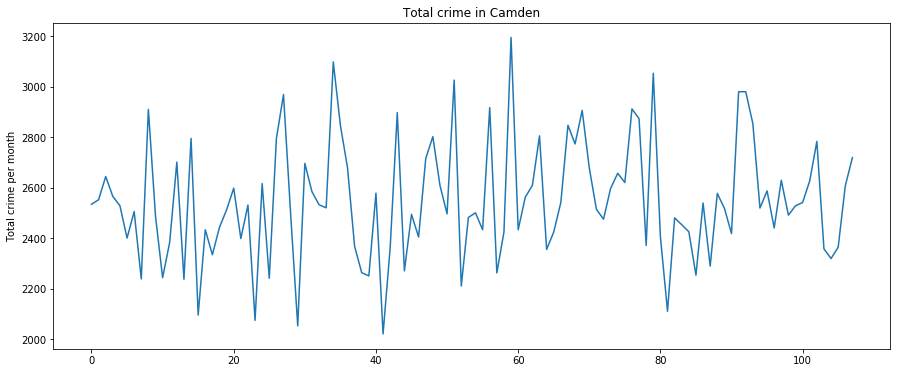

In [12]:
import matplotlib.pyplot as plt
camden_crime.total_crime.plot(figsize=(15, 6))
plt.title('Total crime in Camden')
plt.ylabel('Total crime per month')
plt.xlabel('')
plt.show()

It appears as though crime was roughly on the rise between 2008 and 2011, and then dropped steeply after 2012, before re-establishing an upward trend post-2014. It also appears to fluctuate wildly throughout the months, so I imagine there is some seasonal impact here. 

In [ ]:
cc08_10 = camden_crime.loc['2008':'2010',] # Filter using the datetime index

In [ ]:
cc08_10.total_crime.plot(figsize=(15, 6))
plt.title('Total crime in Camden')
plt.ylabel('Total crime per month')
plt.show()

There are no clear seasonal trends to my eye, perhaps they are clearer when the data is subsetted by the type of crime; some crimes happen more when it is hot, while others thrive in the cold. However, to have that information, we will have to go back and change the initial query so that we also group by the `major_category` (we could also include the `minor_category` but the numbers may be high enough for certain crime types to yeild informative results).

Even if we don't unearth any significant seasonal trends, it will be good to have a deeper look at crime rates in Camden across the years. 

### Delving deeper using `major_category`

In [ ]:
# Query adapted from previous to also group by major_category of crime
camden_major_query = """
SELECT year, month, major_category, sum(value) AS `total_crime`
FROM `bigquery-public-data.london_crime.crime_by_lsoa`
WHERE borough = 'Camden'
GROUP BY year, month, major_category
ORDER BY year, month;
        """
# Perform and store the query results
camden_major = london.query_to_pandas_safe(camden_major_query)
camden_major.head()

I have added an additional grouping of `major_category` after the `year` and `month`. This adds a further breakdown to the `total_crime` column that we had from the previous query. 

Now that we have the results in a pandas data frame, we are able to perform some cleaning and manipulations easily in preparation for plotting in a moment. The steps that I'm going to get to that stage are: 
1. Create a column for the datetime object (as I previously did with the other query) (Set the date time as the index using `set_index`)
2. Spread the major category to make the data wide, rather than long using the `pivot` function (This will allow for us to use the `subplots=True` argument with `matplotlib`)

In [ ]:
camden_major['date'] = pd.to_datetime(camden_major.year.map(str) + '-' + camden_major.month.map(str), format = '%Y-%m')
camden_major.drop(columns = ['year', 'month'], inplace = True)
camden_major.head()

In [ ]:
camden_major_pivot = camden_major.pivot(index = 'date', columns = 'major_category', values = 'total_crime')

In [ ]:
camden_major_pivot.plot(subplots = True, figsize=(15, 15))
plt.show()

The most striking insight that we have gained from this plot is the complete lack of *Fraud or Forgery* or *Sexual Offences* after the first few months of data. This can be seen if we view the first 10 rows of our pivot table as well.  

In [ ]:
camden_major_pivot.head()

We can check whether this was an error I have after the query, or whether the information for those months hasn't been recorded in the data for whatever reason. 

In [ ]:
sanity_check_query = """
SELECT year, month, borough, major_category, minor_category, value
FROM `bigquery-public-data.london_crime.crime_by_lsoa`
WHERE borough = 'Camden' 
AND (major_category = 'Sexual Offences' OR major_category = 'Fraud or Forgery')
AND year > 2008
ORDER BY year, month;
        """
sanity_check = london.query_to_pandas_safe(sanity_check_query)

In [ ]:
sanity_check

Having performed a secondary check to make sure I hadn't accidentally removed data with my pivot table, it seems as though there is a lack of information regarding those major categories of crime for Camden after February 2008. 

If you can see a mistake that I've made, or I've done something stupid, then please leave a comment and let me know! 

### What types of crimes are growing the fastest? 
Instead of looking at it from a borough-centric view as an example, we can have a look at the changes for total `major_category` across time. 

In [ ]:
# Write our query to track the changes in yearly crime count per major_category
growing_crime_query = """
SELECT year, major_category, sum(value) as `total_crime` 
FROM `bigquery-public-data.london_crime.crime_by_lsoa`
GROUP BY major_category, year
ORDER BY major_category, year;
        """

london.estimate_query_size(growing_crime_query) # We can estimate the size of our query this way
growing_crime = london.query_to_pandas(growing_crime_query) # Execute the query and gather the results 

In [ ]:
growing_crime.head(15)

We can see that we have the total crime counts for the major categories across all the years in the data set. Lets plot them and see which crimes are on the rise in London. 


In [ ]:
growing_crime.set_index(pd.to_datetime(growing_crime.year, format = '%Y'), inplace = True)
growing_crime.head()

In [ ]:
growing_crime.drop(columns = ['year'], inplace = True) # Remove the year column since the information is now held in the index
growing_crime_pivot = growing_crime.pivot(columns = 'major_category', values = 'total_crime') # Pivot to make each category a column
growing_crime_pivot.plot(subplots = True, figsize=(20, 15), layout = (5, 2)) # Subplotting to see all plots separately - important since vastly different scales
plt.show() # Show plot

The crimes that appear to be increasing are:
- Violence against the person
- Other notifiable offences 

All the other crimes appear to be in reasonable decline; although note the scaling for the y axis being different for each plot, so while we can see trends, the scales aren't truly comparable. We could calculate the percentage change for each of the major categories, which would give us a better indication as to the true problem crimes that aren't being tackled. 

*NB: we have double checked our thoughts about the Sexual Offences and Fraud or Forgery major categories here, with records of them seemingly disappearing after the first year (2008).*

## Analysis Flexibility 
While working with Big Query, we are really given two options to how we are able to conduct our analysis and do our calculations:
1. Within the original SQL query
2. Working with the pandas data frame that is produced when the query is run

I suppose which you preference is probably a personal choice, depending on the task and your strengths with the languages involved. I just wanted to demonstrate this through solving one problem using both methods: by changing the original query to add the column, or adding it afterwards using python. 

__*Can we add a column that shows the percentage change from the previous year for each major cirme category?*__

### Python (use pandas):



In [ ]:
# Calculate the percent change from the previous year's figure
growing_crime['percent_change'] = growing_crime['total_crime'] / growing_crime['total_crime'].groupby(growing_crime['major_category']).shift(1) - 1
# NB I tried to use pct_change() but couldn't get it to work with a groupby() as well
growing_crime.head(20)

### SQL (change the original query):

In [ ]:
# Write our query to track the changes in yearly crime count per major_category
growing_crime_query_2 = """
SELECT 
    year, 
    major_category, 
    SUM(value) as `total_crime`,
    CASE WHEN SUM(value) > 0
        THEN SUM(value) / LAG(SUM(value) , 1 , NULL) OVER (PARTITION BY major_category ORDER BY year ASC) - 1
        ELSE 0 END AS `percent_change`
FROM `bigquery-public-data.london_crime.crime_by_lsoa`
GROUP BY major_category, year
ORDER BY major_category, year;
        """

growing_crime_2 = london.query_to_pandas(growing_crime_query_2) # Execute the query and gather the results 

In [ ]:
growing_crime_2.head(20)

There we go! We can see that we have produced, essentially, the same results through the two different methods that I talked about. 

- - - - -
### Conclusions and final comments
This is just a simple introduction to querying the Big Query datasets using `bq_helper`. I may explore further over time so it may become more fleshed out in the coming weeks/months. 

Thank you for taking the time to have a look through, and follow my workflow through the process of learning some more about Big Query. Please consider leaving an upvote if you think it is worth it, and please leave a comment if you have any feedback, constructive comments and suggestions are always welcome and appreciated!